In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import wandb

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eraldoluis (use `wandb login --relogin` to force relogin)


True

In [3]:
api = wandb.Api()
sweep_ids = ["1qcd2x0p", "dwqldmag", "s3jg6oju", "cw2quf1k", "68wrws1j"]
sweeps = [api.sweep(f"eraldoluis/WeightedCRF/{sweep_id}") for sweep_id in sweep_ids]

In [4]:
runs = [run for sweep in sweeps for run in sweep.runs]
# run = next(runs)
# next(run.scan_history(keys=["model.label_weights.O", "validation/macro-fscore"]))
len(runs)

435

In [5]:
import pandas as pd 
# import wandb
# api = wandb.Api()

# # Project is specified by <entity/project-name>
# runs = api.runs("eraldoluis/WeightedCRF")

tags = ["O", "PER", "LOC", "ORG", "MISC"]

# columns to select
cols = ["name", "model.label_weights"]
cols += [f"validation/macro-{m}" for m in ["fscore", "precision", "recall"]]
cols += [f"validation/{tag}-{m}" for tag in tags for m in ["fscore", "precision", "recall"]]

values = []
for run in runs: 
    # .name is the human-readable name of the run.
    val = {"name": run.name}

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    # val.update({
    #     k: v for k, v in run.config.items() 
    #         if not k.startswith('_') and "label_weights" in k})
    val.update({k: v for k, v in run.config.items() if k in cols})

    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    val.update({k: v for k, v in run.summary._json_dict.items() if k in cols})

    values.append(val)

runs_df = pd.DataFrame(values, columns=cols)

In [6]:
runs_df.head(5)

,name,model.label_weights,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,validation/O-precision,validation/O-recall,validation/PER-fscore,validation/PER-precision,validation/PER-recall,validation/LOC-fscore,validation/LOC-precision,validation/LOC-recall,validation/ORG-fscore,validation/ORG-precision,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall
0,crimson-sweep-20,{'MISC': 1.2},0.869368,0.869571,0.870169,0.993459,0.994145,0.992773,0.914546,0.904880,0.924420,0.878170,0.915975,0.843362,0.761135,0.735832,0.788241,0.799528,0.797022,0.802050
1,wandering-sweep-19,{'MISC': 1.15},0.829785,0.845316,0.834931,0.993420,0.992852,0.993990,0.807836,0.979195,0.687520,0.862128,0.888101,0.837631,0.683986,0.575342,0.843212,0.801556,0.791091,0.812303
2,hearty-sweep-18,{'MISC': 1.1},0.869199,0.881648,0.863239,0.991167,0.986449,0.995931,0.890830,0.945455,0.842172,0.893453,0.904157,0.882999,0.824349,0.895238,0.763862,0.746195,0.676943,0.831230
3,glowing-sweep-17,{'MISC': 1.05},0.845236,0.879502,0.838979,0.994335,0.993302,0.995369,0.839413,0.960704,0.745316,0.729086,0.594399,0.942693,0.806824,0.894645,0.734704,0.856522,0.954457,0.776814
4,stellar-sweep-16,{'LOC': 1.2},0.861782,0.873831,0.857162,0.993303,0.992850,0.993756,0.883798,0.918780,0.851381,0.869508,0.798323,0.954632,0.736193,0.730136,0.742352,0.826106,0.929064,0.743691


In [7]:
base_dict = {k: 1.0 for k in tags}
def transf(w):
    new_d = dict(base_dict)
    new_d.update(w)
    new_d = {f"label_weight_{k}": v for k, v in new_d.items()}
    return pd.Series(new_d)

df_runs_weights = pd.concat([runs_df, runs_df["model.label_weights"].apply(transf)], axis=1)

In [8]:
df_runs_weights.sample(5)

,name,model.label_weights,validation/macro-fscore,validation/macro-precision,validation/macro-recall,validation/O-fscore,validation/O-precision,validation/O-recall,validation/PER-fscore,validation/PER-precision,...,validation/ORG-precision,validation/ORG-recall,validation/MISC-fscore,validation/MISC-precision,validation/MISC-recall,label_weight_O,label_weight_PER,label_weight_LOC,label_weight_ORG,label_weight_MISC
209,dry-sweep-2,{'O': 1.05},0.816319,0.822574,0.821308,0.993518,0.992301,0.994738,0.847608,0.878664,...,0.784355,0.709369,0.632462,0.535227,0.772871,1.05,1.00,1.0,1.00,1.0
87,crimson-sweep-22,{'PER': 1.05},0.836029,0.870641,0.821509,0.992171,0.988509,0.995861,0.872446,0.949552,...,0.865196,0.674952,0.814717,0.916256,0.733438,1.00,1.05,1.0,1.00,1.0
153,bumbling-sweep-57,{'ORG': 0.8},0.823166,0.839345,0.829724,0.993216,0.991791,0.994644,0.783991,0.987458,...,0.606071,0.858987,0.781447,0.778997,0.783912,1.00,1.00,1.0,0.80,1.0
315,visionary-sweep-120,{'ORG': 1.05},0.839976,0.840785,0.846776,0.993053,0.994906,0.991207,0.861747,0.924982,...,0.689119,0.890057,0.759735,0.800175,0.723186,1.00,1.00,1.0,1.05,1.0
2,hearty-sweep-18,{'MISC': 1.1},0.869199,0.881648,0.863239,0.991167,0.986449,0.995931,0.890830,0.945455,...,0.895238,0.763862,0.746195,0.676943,0.831230,1.00,1.00,1.0,1.00,1.1


In [9]:
sels = [df_runs_weights[f"label_weight_{tag}"] == 1.0 for tag in tags]
for i, s in enumerate(sels):
    print(f"{tags[i]}: {len(s) - s.sum()}")

O: 80
PER: 80
LOC: 80
ORG: 80
MISC: 80


In [10]:
import numpy as np
def get_sel(idx):
    sels_diff = [s for i, s in enumerate(sels) if i != idx]
    sels_diff_and = sels_diff[0]
    for s in sels_diff[1:]:
        sels_diff_and = (sels_diff_and & s)
    return df_runs_weights[sels_diff_and]

In [11]:
def plot_metrics(tag):
    value_cols = [
        "validation/macro-fscore", 
        f"validation/{tags[tag]}-fscore",
        f"validation/{tags[tag]}-precision",
        f"validation/{tags[tag]}-recall"
    ]
    df = get_sel(tag).melt(id_vars=[f"label_weight_{tags[tag]}"], value_vars=value_cols)
    sns.lineplot(data=df, x=f"label_weight_{tags[tag]}", y="value", hue="variable")

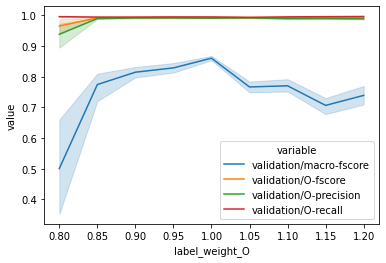

In [12]:
plot_metrics(0)

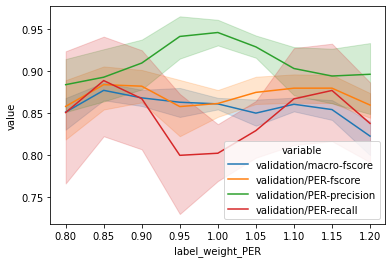

In [13]:
plot_metrics(1)

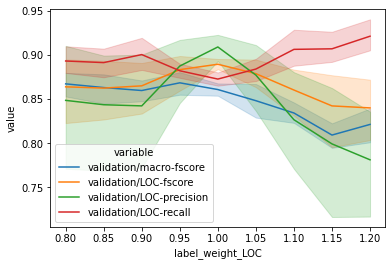

In [14]:
plot_metrics(2)

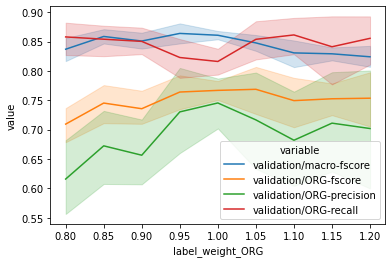

In [15]:
plot_metrics(3)

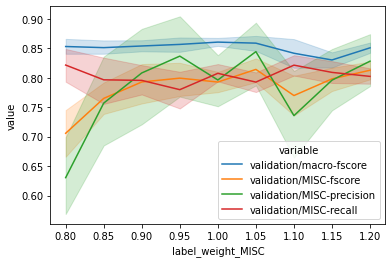

In [16]:
plot_metrics(4)